In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# For validation and test, do not use augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_root = '/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset' 
full_dataset = ImageFolder(root=dataset_root, transform=None)
print("Detected classes:", full_dataset.classes)

Detected classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [5]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [6]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  

    plt.tight_layout()
    plt.show()

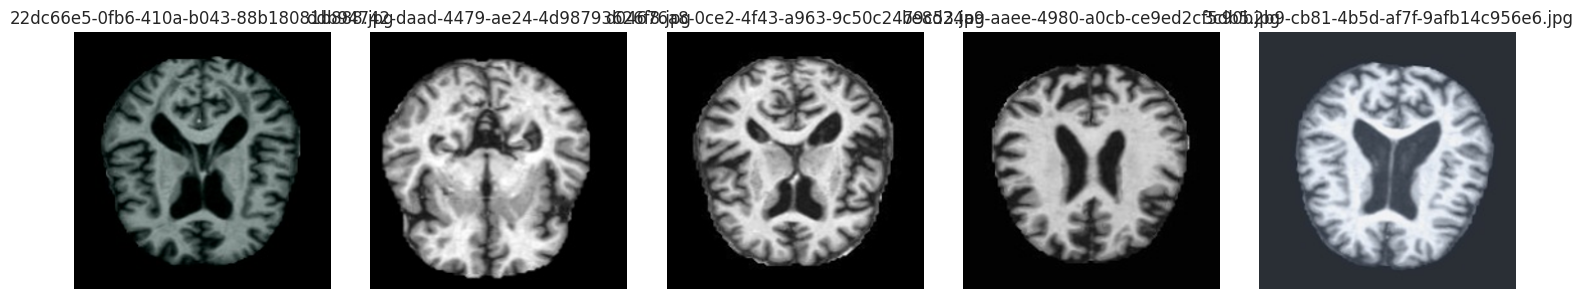

In [7]:
path_to_visualize = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented"
visualize_images(path_to_visualize, num_images=5)

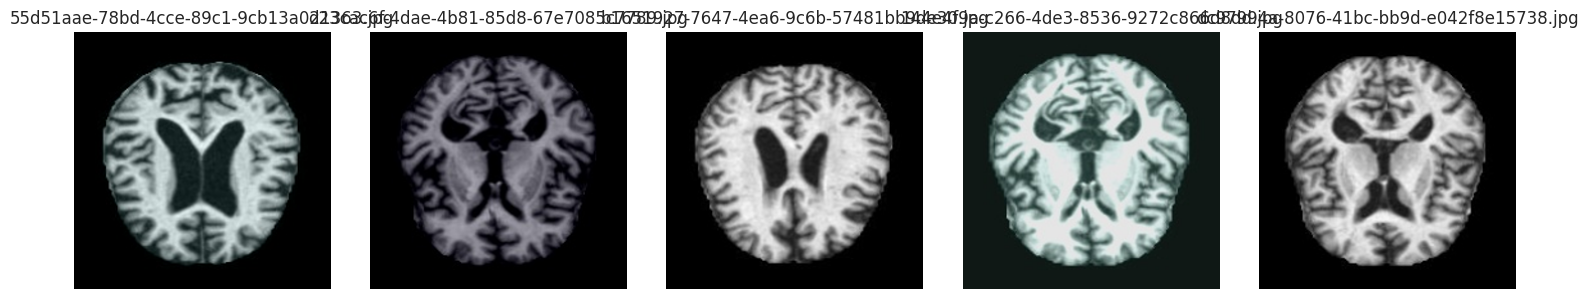

In [8]:
path_to_visualize = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented"
visualize_images(path_to_visualize, num_images=5)

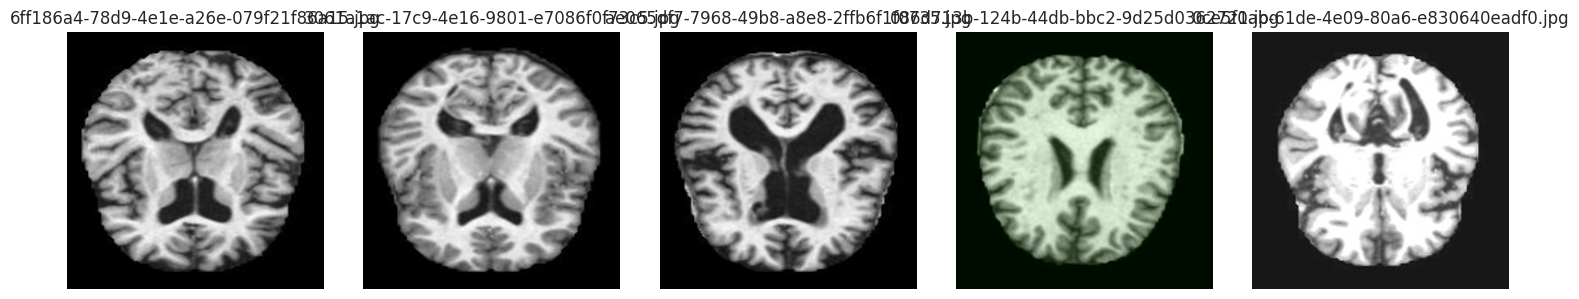

In [9]:
path_to_visualize = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented"
visualize_images(path_to_visualize, num_images=5)

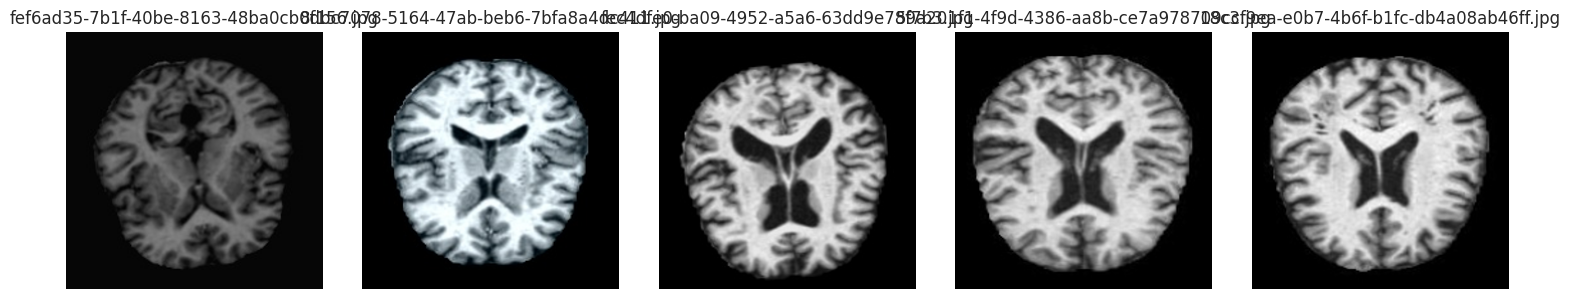

In [10]:
path_to_visualize = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented"
visualize_images(path_to_visualize, num_images=5)

In [11]:
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size 

In [12]:
print(f"Total size: {total_size}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Total size: 33984
Train size: 27187
Validation size: 3398
Test size: 3399


In [13]:
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])
train_dataset = TransformDataset(train_subset, transform=train_transform)
val_dataset   = TransformDataset(val_subset, transform=val_transform)
test_dataset  = TransformDataset(test_subset, transform=val_transform)


In [14]:
batch_size = 64
num_workers = 16  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4

In [16]:
# Load the pretrained VGG19 model
vgg19_model = models.vgg19(pretrained=True)

# Modify the last layer to match your number of classes
num_features = vgg19_model.classifier[6].in_features
vgg19_model.classifier[6] = nn.Linear(num_features, num_classes)

# Move model to device (GPU/CPU)
vgg19_model = vgg19_model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:01<00:00, 344MB/s] 


In [17]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(vgg19_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    best_acc = 0.0
    best_model_wts = None
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
        scheduler.step()

    print("Best validation accuracy: {:.4f}".format(best_acc))
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

def test_model_with_report(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    overall_acc = accuracy_score(all_labels, all_preds)
    print("\nOverall Test Accuracy: {:.4f}".format(overall_acc))

    class_names = full_dataset.classes
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print("Per Class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"Class {i} ({class_names[i]}): {acc:.4f}")

    return overall_acc, report, per_class_acc


In [19]:
num_epochs = 5
print("Training VGG19 on new dataset with 80/10/10 split...")
trained_vgg19, vgg_train_losses, vgg_train_accs, vgg_val_losses, vgg_val_accs = train_model(
    vgg19_model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs
)


Training VGG19 on new dataset with 80/10/10 split...

Epoch 1/5


Train Loss: 1.0723, Train Acc: 0.4835
Val Loss: 0.6803, Val Acc: 0.6742

Epoch 2/5


Train Loss: 0.7614, Train Acc: 0.6416
Val Loss: 0.6306, Val Acc: 0.7181

Epoch 3/5


Train Loss: 0.6630, Train Acc: 0.6870
Val Loss: 0.5126, Val Acc: 0.7569

Epoch 4/5


Train Loss: 0.5950, Train Acc: 0.7274
Val Loss: 0.4955, Val Acc: 0.7625

Epoch 5/5


Train Loss: 0.5133, Train Acc: 0.7649
Val Loss: 0.3820, Val Acc: 0.8167
Best validation accuracy: 0.8167


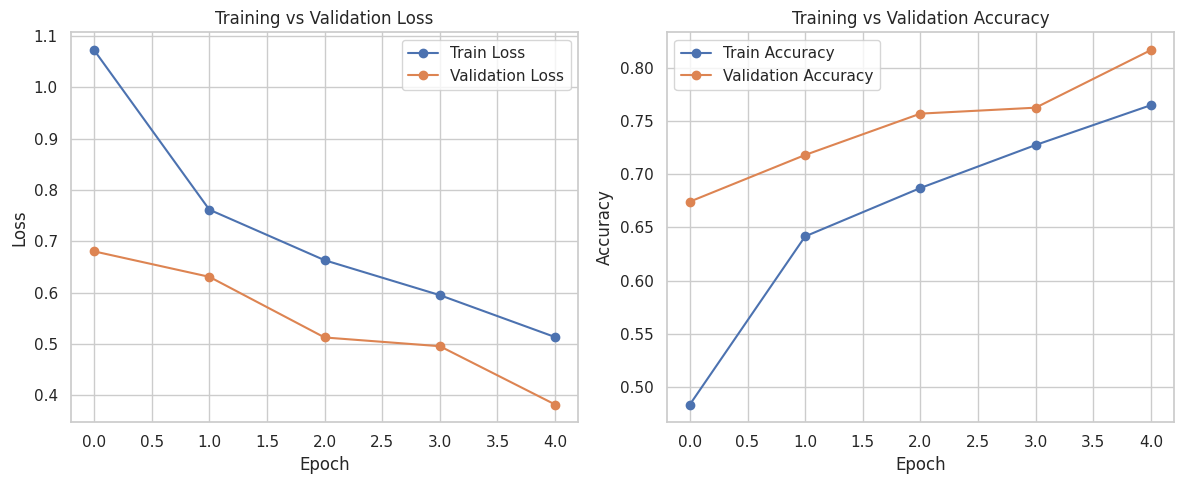

In [20]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(vgg_train_losses, label="Train Loss", marker="o")
plt.plot(vgg_val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(vgg_train_accs, label="Train Accuracy", marker="o")
plt.plot(vgg_val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Overall Test Accuracy: 0.8405

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.94      0.98      0.96       885
ModerateDemented       1.00      1.00      1.00       645
     NonDemented       0.93      0.52      0.67       937
VeryMildDemented       0.65      0.92      0.76       932

        accuracy                           0.84      3399
       macro avg       0.88      0.85      0.85      3399
    weighted avg       0.87      0.84      0.83      3399



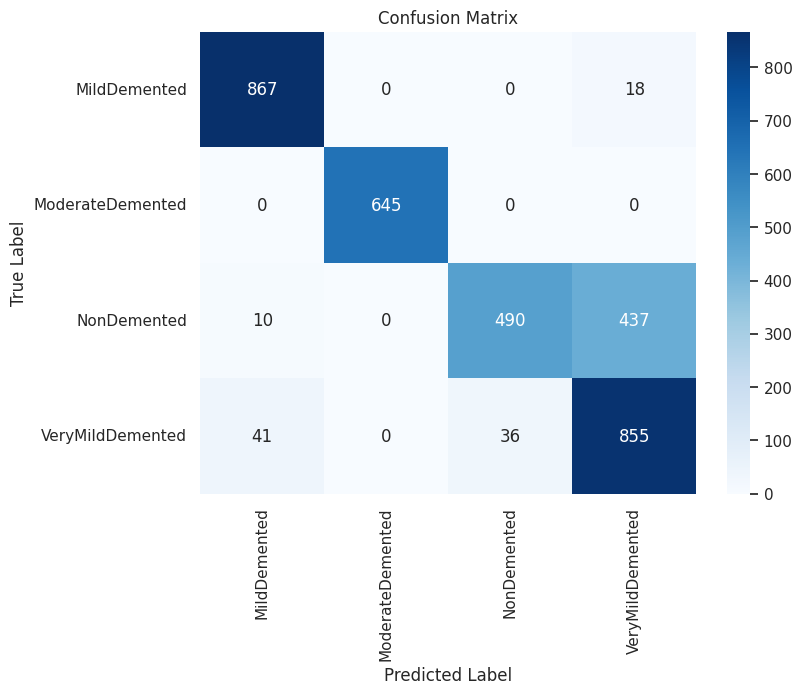

Per Class Accuracy:
Class 0 (MildDemented): 0.9797
Class 1 (ModerateDemented): 1.0000
Class 2 (NonDemented): 0.5229
Class 3 (VeryMildDemented): 0.9174
Final Results for VGG19:
Overall Accuracy: 0.8405

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.94      0.98      0.96       885
ModerateDemented       1.00      1.00      1.00       645
     NonDemented       0.93      0.52      0.67       937
VeryMildDemented       0.65      0.92      0.76       932

        accuracy                           0.84      3399
       macro avg       0.88      0.85      0.85      3399
    weighted avg       0.87      0.84      0.83      3399


Per Class Accuracy:
Class 0: 0.9797
Class 1: 1.0000
Class 2: 0.5229
Class 3: 0.9174


In [21]:
overall_acc, class_report, per_class_acc = test_model_with_report(trained_vgg19, test_loader, device)

results = {
    "VGG-19": {
        "overall_accuracy": overall_acc,
        "classification_report": class_report,
        "per_class_accuracy": per_class_acc
    }
}

print("Final Results for VGG19:")

overall_acc = results["VGG-19"]["overall_accuracy"]
print("Overall Accuracy: {:.4f}".format(overall_acc))

print("\nClassification Report:\n")
print(results["VGG-19"]["classification_report"])

print("\nPer Class Accuracy:")
per_class_acc = results["VGG-19"]["per_class_accuracy"]
for idx, acc in enumerate(per_class_acc):
    print("Class {}: {:.4f}".format(idx, acc))